This practical work, on motion estimation, has 2 different parts, corresponding to two families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [30]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x19069a62fd0>)

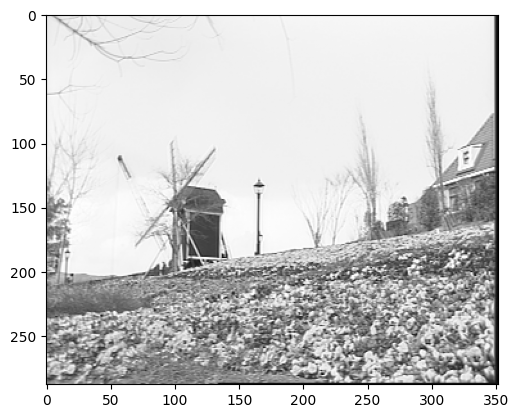

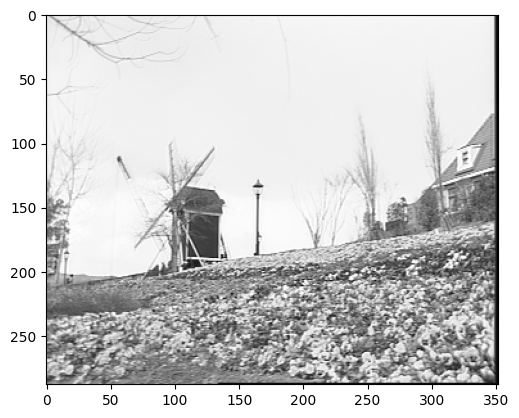

In [97]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [133]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius

Fill the me_ssd function in the cell below. First, implement the unregularized part of the function (you will implement the regularized one later). Do not pay attention to the computePredictor and initVector (we will speak about them later on).

In [4]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) 
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    search_range = range(-search,search+1)
    
    # Non-regularized search
    if lamb == 0.:
        
        for row in range(0,cur.shape[0],brow): # for each block in the current image, find the best corresponding block in the reference image
            for col in range(0,cur.shape[1],bcol):
                # current block selection
                B = cur[row:row+brow,col:col+bcol] # Block

                # Initialization:
                bestvect = (0,0)
                costMin = float('inf')
                
                Rbest = B
                
                # Loop on candidate displacement vectors
                for dcol in search_range: # dcol = candidate displacement vector over the columns
                    for drow in search_range:# rcol = candidate displacement vector over the rows

                        row_start = row + drow + extension
                        col_start = col + dcol + extension
                        curr_ref_block = ref_extended[row_start:row_start+brow, col_start:col_start+bcol]
                        curr_cost = np.sum((B - curr_ref_block)**2)
                        
                        if curr_cost < costMin: # Save the results if they are better than the previous ones
                            costMin = curr_cost
                            Rbest = curr_ref_block
                            bestvect = (drow,dcol)
                        
                mvf[row:row+brow,col:col+bcol,0]= bestvect[0] # Once the loop is over, save the best row displacement field
                mvf[row:row+brow,col:col+bcol,1]= bestvect[1] # Once the loop is over, save the best column displacement field
                prediction[row:row+brow,col:col+bcol]= Rbest
                
    else: # Regularized search

        for row in range(0,cur.shape[0]-brow,brow): # for each block in the current image, find the best corresponding block in the reference image
            for col in range(0,cur.shape[1]-bcol,bcol):
                # current block selection
                B = cur[row:row+brow,col:col+bcol] # Block

                # Initialization:

                bestvect = (0,0)
                costMin = float('inf')
                
                Rbest = B
                
                # Loop on candidate displacement vectors
                for dcol in search_range: # dcol = candidate displacement vector over the columns
                    for drow in search_range:# rcol = candidate displacement vector over the rows

                        row_start = row + drow + extension
                        col_start = col + dcol + extension
                        curr_ref_block = ref_extended[row_start:row_start+brow, col_start:col_start+bcol]

                        vect = np.array([drow,dcol])

                        pV = computePredictor(row,col,brow,bcol,mvf,ref,cur)

                        dx,dy = vect - pV

                        cost = np.sum((curr_ref_block-B)**2) + lamb * np.sqrt(dx**2 + dy**2)
                        
                        if cost < costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = curr_ref_block  
                            bestvect = vect
                        
                mvf[row:row+brow,col:col+bcol,0]= bestvect[0] # Once the loop is over, save the best row displacement field
                mvf[row:row+brow,col:col+bcol,1]= bestvect[1] # Once the loop is over, save the best column displacement field
                prediction[row:row+brow,col:col+bcol]=Rbest
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [100]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

Using the function displayMVF, show the motion vector field. Write your remarks. Are there errors? If yes, where and why?

Change the block size and the search area radius. How does it impact your results?

# Answers

A lot of close vectors give contradictory directions. Since we only work on motion there might be errors. These errors mainly appear on homogeneous blocks (i.e. sky) where it is easier to find a similar block that should not be one.

Vector sizes depend on the size of our blocks so bigger blocks make bigger bigger vectors. It also means that we can not be really precise. 

Increasing the radius also increases the number of errors.

In [5]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    
    return

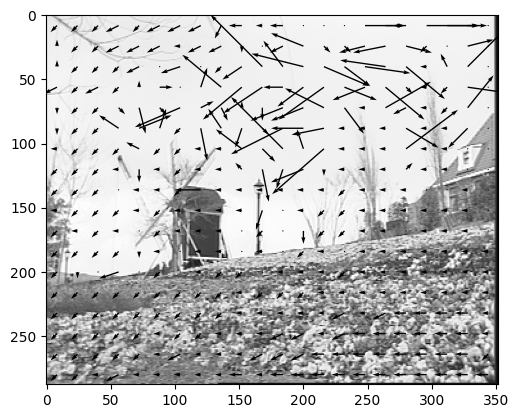

In [102]:
displayMVF(im1,mvf_ssd,brow)

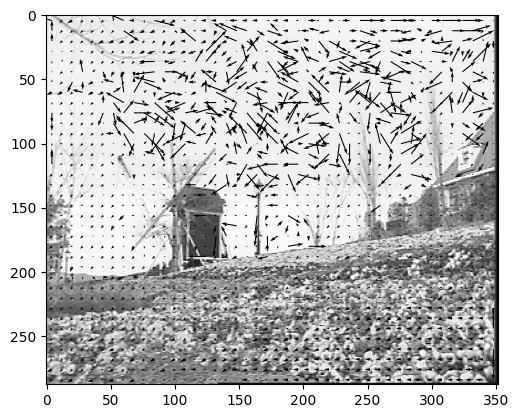

In [103]:
mvf_ssd2,prediction2 =  me_ssd(im2, im1, 8, 8, 8)
displayMVF(im1,mvf_ssd2,8)

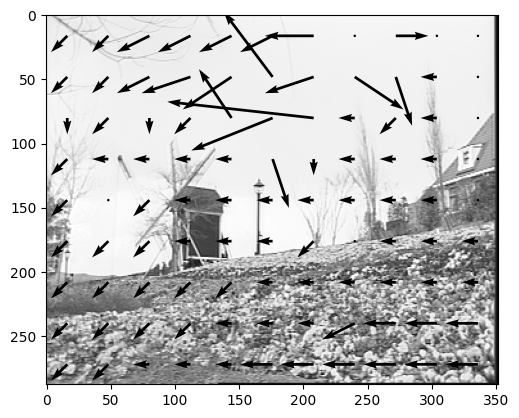

In [104]:
mvf_ssd2,prediction2 =  me_ssd(im2, im1, 32, 32, 16)
displayMVF(im1,mvf_ssd2,32)

Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image using the fracMc function. Display the motion compensated image. What can you observe ?

# Answer

Vector field changed but it is not convincing. The estimation errors creates artefacts as we can on the top of the floor lamp in the middle of the picture which has been doubled.

In [11]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1906a6db450>)

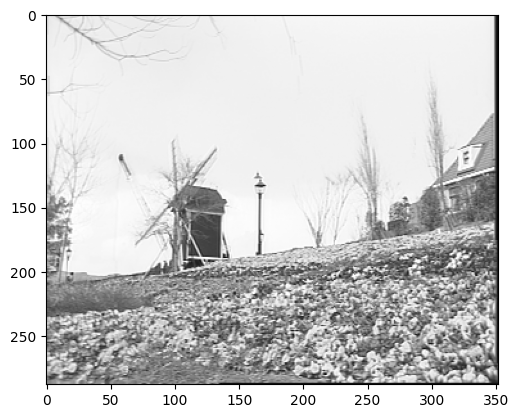

In [106]:
mc_ssd = fracMc(im1,mvf_ssd)
plt.figure(),plt.imshow(mc_ssd,cmap='gray')

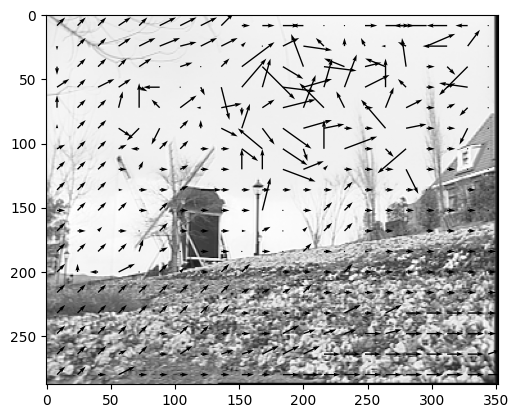

In [107]:
new_ssd,prediction =  me_ssd(mc_ssd,im2, brow, bcol, search_radius)
displayMVF(im2,new_ssd,brow)


Compute the PSNR between the motion compensated and the current images.

Recall the definition of PSNR. Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

# Answers

$PSNR = 10 \cdot \log_{10} \left( \frac{MAX_I^2}{MSE} \right)$

where \( MAX_I \) is the maximum possible pixel value of the image and \( MSE \) is the mean squared error between the original and the compressed image. The greater the PSNR value is the better it is.

As expected the greater the search radius is the worse is the result (lower psnr).

It is worse because we have too much errors and we need regularization.

In [7]:
def PSNR(im1,im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : nparray
        Two images.

    Returns
    -------
    psnr : float
    """
    n,m = im1.shape
    mse = np.sum((im1-im2)**2)/(n*m)
    psnr = 10*np.log10(max(max(im1.reshape(-1)),max(im2.reshape(-1)))**2/mse)
    
    return psnr

In [31]:
for search in np.arange(8,24,4):
    mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search)
    mc_ssd = fracMc(im1,mvf_ssd)
    psnr = PSNR(im2,mc_ssd)
    print(f'''For search radius {search}, PSNR = {psnr}''')

For search radius 8, PSNR = 16.460076383673186
For search radius 12, PSNR = 16.458918274136614
For search radius 16, PSNR = 16.458704686485987
For search radius 20, PSNR = 16.45884146066291


In [109]:
psnr_ssd = PSNR(im2,im1)
print(psnr_ssd)

18.786509322935075


In [110]:
psnr_ssd = PSNR(im2,mc_ssd)
print(psnr_ssd)

16.460076383673186


### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the unregularized part of the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [9]:
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV
#%%
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))

    search_range = range(-search,search+1)
    
    # Non-regularized search
    if lamb == 0.:
        for row in range(0,cur.shape[0]-brow,brow): # for each block in the current image, find the best corresponding block in the reference image
            for col in range(0,cur.shape[1]-bcol,bcol):
                # current block selection
                B = cur[row:row+brow,col:col+bcol] # Block

                # Initialization:
                bestvect = (0,0)
                costMin = float('inf')
                
                Rbest = None
                
                # Loop on candidate displacement vectors
                for dcol in search_range: # dcol = candidate displacement vector over the columns
                    for drow in search_range:# rcol = candidate displacement vector over the rows

                        row_start = row + drow + extension
                        col_start = col + dcol + extension
                        curr_ref_block = ref_extended[row_start:row_start+brow, col_start:col_start+bcol]

                        cost = np.sum(np.abs(B-curr_ref_block))
                        
                        if cost < costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = B
                            bestvect = (drow,dcol)
                        
                mvf[row:row+brow,col:col+bcol,0]=bestvect[0] # Once the loop is over, save the best row displacement field
                mvf[row:row+brow,col:col+bcol,1]=bestvect[1]# Once the loop is over, save the best column displacement field
                prediction[row:row+brow,col:col+bcol]= Rbest

    else: # Regularized search

        for row in range(0,cur.shape[0]-brow,brow): # for each block in the current image, find the best corresponding block in the reference image
            for col in range(0,cur.shape[1]-bcol,bcol):
                # current block selection
                B = cur[row:row+brow,col:col+bcol] # Block

                # Initialization:

                bestvect = (0,0)
                costMin = float('inf')
                
                Rbest = None
                
                # Loop on candidate displacement vectors
                for dcol in search_range: # dcol = candidate displacement vector over the columns
                    for drow in search_range:# rcol = candidate displacement vector over the rows

                        row_start = row + drow + extension
                        col_start = col + dcol + extension
                        curr_ref_block = ref_extended[row_start:row_start+brow, col_start:col_start+bcol]

                        vect = np.array([drow,dcol])

                        pV = computePredictor(row,col,brow,bcol,mvf,ref,cur)

                        dx,dy = vect - pV

                        cost = np.sum(np.abs(curr_ref_block-B)) + lamb * np.sqrt(dx**2 + dy**2)
                        
                        if cost < costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = B
                            bestvect = vect
                        
                mvf[row:row+brow,col:col+bcol,0]= bestvect[0] # Once the loop is over, save the best row displacement field
                mvf[row:row+brow,col:col+bcol,1]= bestvect[1] # Once the loop is over, save the best column displacement field
                prediction[row:row+brow,col:col+bcol]=Rbest
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [134]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius)

Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.

# Answer

The result is almost the same but some vectors are bigger in the case of SSD.

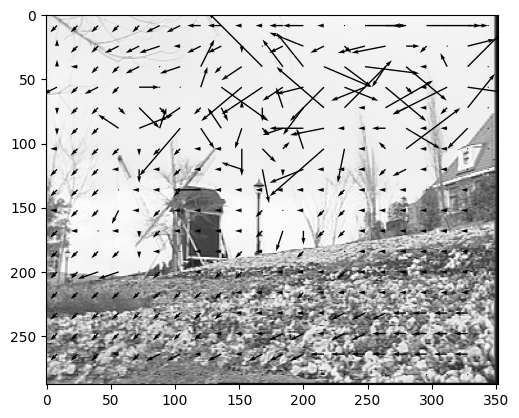

In [135]:
displayMVF(im1,mvf_sad,brow)

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

# Answers

SAD gives a better regularization and a better PSNR (not much). It has a smoother field than the SSD and it's more robust to outliers as the error vectors are smaller than SSD. Moreover the prediction error is smaller when we have smaller blocks.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x190696da690>)

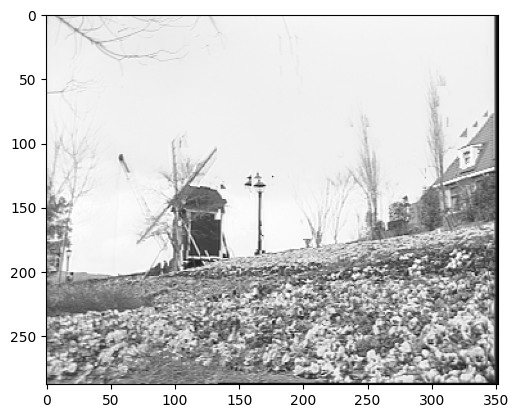

In [127]:
mc_sad = fracMc(im1,mvf_sad)
plt.figure(),plt.imshow(mc_sad,cmap='gray')

In [128]:
psnr_sad = PSNR(im2,mc_sad)
print(psnr_sad)

16.486817890256223


In [129]:
# change of block size
brow = 8 # Number of rows per block
bcol = 8 # Number of columns per block
search_radius = 8 # Search radius

mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius)

mc_ssd = fracMc(im1,mvf_ssd)
mc_sad = fracMc(im1,mvf_sad)

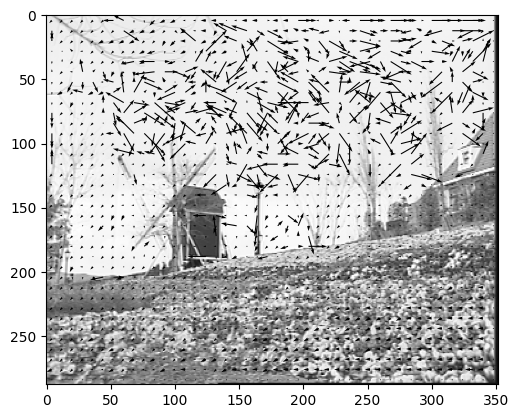

In [130]:
displayMVF(im1,mvf_sad,brow)

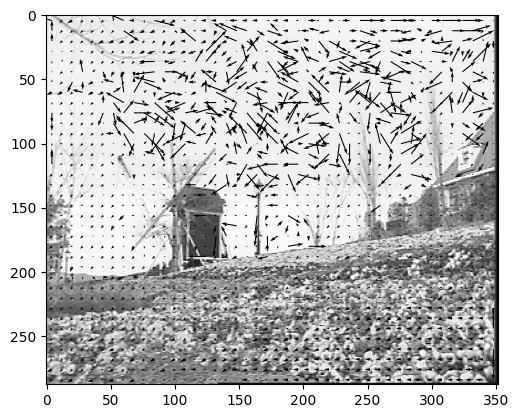

In [131]:
displayMVF(im1,mvf_ssd,brow)

In [132]:
PSNR(im2,mc_ssd), PSNR(im2,mc_sad)

(np.float64(16.41138892259574), np.float64(16.486817890256223))

## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

TO DO : code the regularized SSD-based algorithm.
For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

# Answers

We can see that the PSNR value depends on lambda. It means that we can find a lambda that maximizes our PSNR. Also the result makes more sense since there is a common direction that most vectors share.  

PSNR for lambda = 0.1 : 31.658506939982377
PSNR for lambda = 1 : 31.676320854117566
PSNR for lambda = 10 : 31.60544238211107
PSNR for lambda = 50 : 31.808885865340063


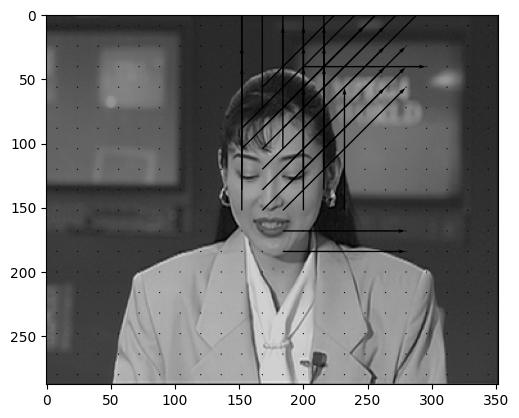

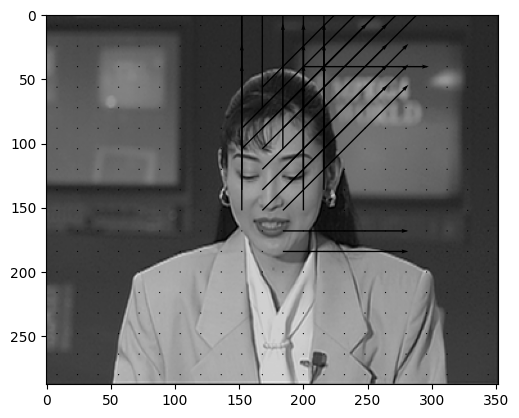

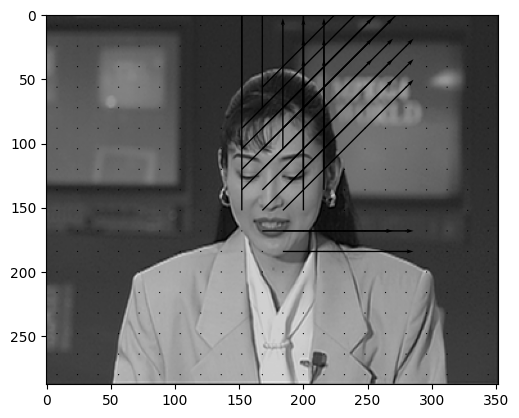

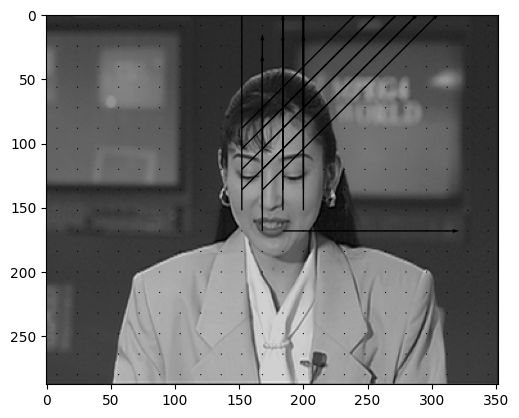

In [25]:
for lamb in [0.1, 1, 10, 50]:
    mvf_ssd,prediction =  me_ssd(im2, im1, 16, 16, 8, lamb=lamb)
    mc_ssd = fracMc(im1,mvf_ssd)
    displayMVF(im1,mvf_ssd,16)
    psnr_lamb = PSNR(im2,mc_ssd)
    print(f'PSNR for lambda = {lamb} : {psnr_lamb}')

### I-2-2- Regularized SAD-based algorithm

TO DO : code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

# Answer 

In the same way the quality of the results depend on lambda and this time it seems it depends stronglier on this parameter. Once again the effect of regularization appears clearly.

PSNR for lambda = 0.1 : 16.664247166129623
PSNR for lambda = 0.5 : 16.677755865238755
PSNR for lambda = 1 : 16.697513368051077
PSNR for lambda = 5 : 16.390368515753494
PSNR for lambda = 10 : 17.889082183503938


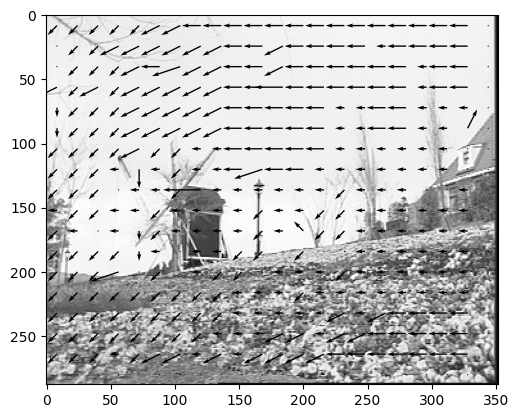

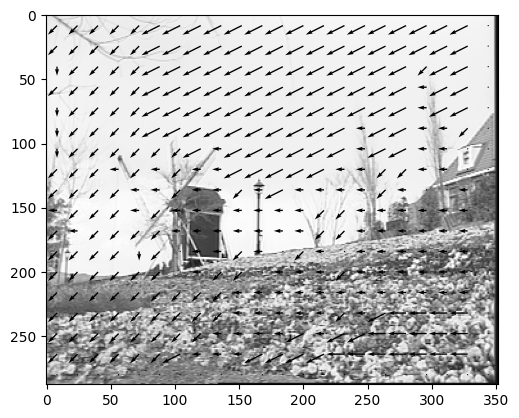

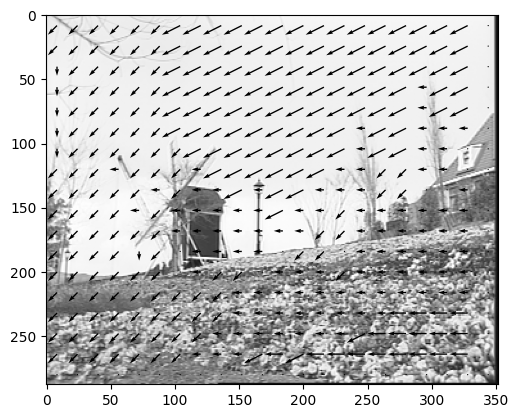

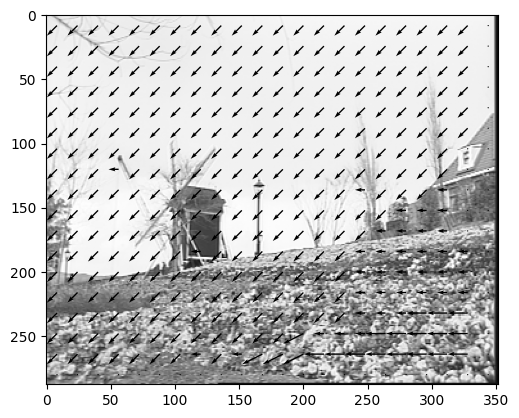

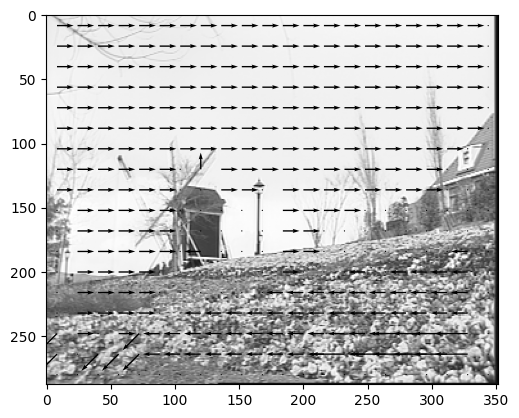

In [ ]:
for lamb in [0.1, 1, 10, 50]:
    mvf_sad,prediction =  me_sad(im2, im1, 16, 16, 8, lamb=lamb)
    mc_sad = fracMc(im1,mvf_sad)
    displayMVF(im1,mvf_sad,16)
    psnr_lamb = PSNR(im2,mc_sad)
    print(f'PSNR for lambda = {lamb} : {psnr_lamb}')

# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [15]:
im1 = loadmat('akiyo_cif1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('akiyo_cif2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1c2f6564c10>)

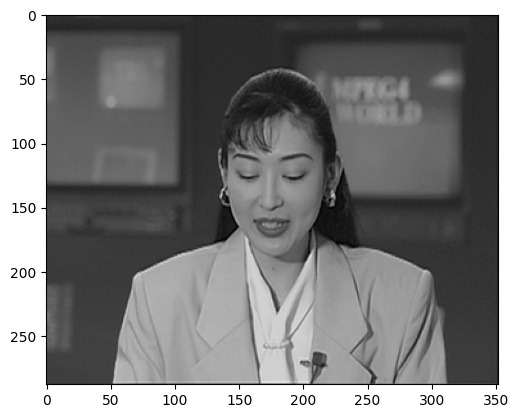

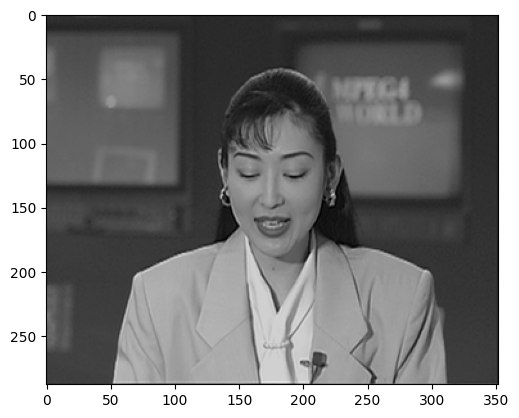

In [16]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithm to initialize the Horn and Schunck method.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

In [17]:
brow = 16; bcol=16; search_radius =13;

mvf_ssd, prediction = me_ssd(im2, im1, brow, bcol, search_radius, lamb=0)




In [21]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg = convolve2d(u, kernel_1, mode='same', boundary='symm')
        vAvg = convolve2d(v, kernel_1, mode='same', boundary='symm')
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx*(uAvg*fx +vAvg*fy + ft) / (alpha**2 + fx**2 + fy**2 + ft**2)
        v = vAvg - fy*(uAvg*fx + vAvg*fy + ft) / (alpha**2 + fx**2 + fy**2 + ft**2)
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

In [23]:
alpha = 100
ite = 100

uInitial = mvf_ssd[:, :, 1]
vInitial = mvf_ssd[:, :, 0]

[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

# Answers

We can see that the Horn and Schunck algorithm improve the PSNR compared to previous block-matching algorithms because the optical flow approach computes a dense motion estimation (a vector per pixel is estimated) which implies a more continuous movement field estimation and a better accuracy in the motion compensation. It's important to precise that here we have really small movements and almost no noise which makes the optical flow better than block-matching but it could be inversed in case of noise.

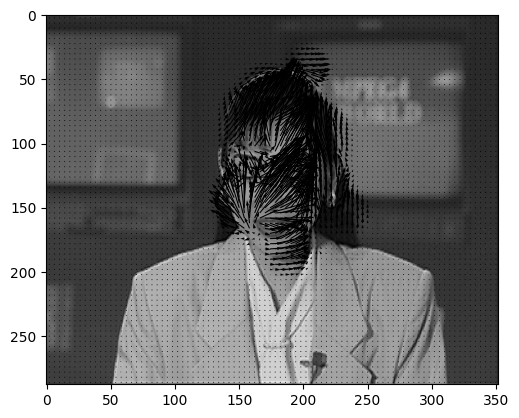

In [24]:
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)

mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

In [34]:
psnr_hs

np.float64(38.04833844976826)

In [141]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

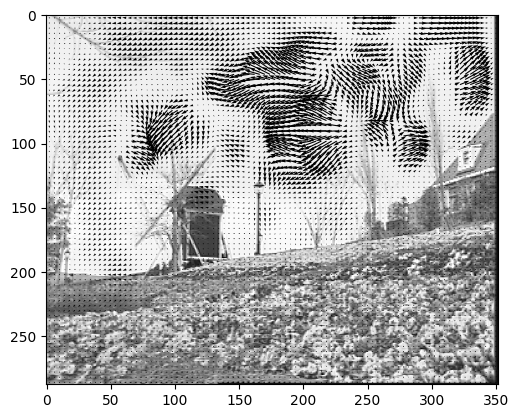

In [142]:
brow = 16; bcol=16; search_radius =13;

mvf_ssd, prediction = me_ssd(im2, im1, brow, bcol, search_radius, lamb=0)


alpha = 100
ite = 100

uInitial = mvf_ssd[:, :, 1]
vInitial = mvf_ssd[:, :, 0]

[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)


In [145]:
mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

print(psnr_hs)  

20.0726282183324
